# Bike Sharing: Predicción de Demanda Horaria

In [157]:
#Import
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor as Tree
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
import scipy.stats as stats
import seaborn as sn
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVC as SVM
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor

(a) Cargue los datos de entrenamiento y pruebas como dataframes de pandas. Describa las variables involucradas
en el problema, explorando el tipo de datos de que se trata, el número de valores distintos y, si
corresponde, un gráfico (e.g. un histograma) que resuma su comportamiento. Su primera operación de
pre-procesamiento de datos será obtener la hora del día desde el campo fecha (que en este momento es
de tipo string), creando una nueva columna denominada hour y de tipo int. Para hacer esta operación
se concatenarán los dataframes de entrenamiento y pruebas y luego se volverán a separar manteniendo
la separación original.


In [76]:
dftrain = pd.read_csv('./dataset2/bike_sharing_train.csv')
dfval = pd.read_csv('./dataset2/bike_sharing_val.csv')
dftest = pd.read_csv('./dataset2/bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['hour'] = pd.to_numeric(df['hour'])

In [77]:
df.head()

,Unnamed: 0,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
0,3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,3
1,4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,4
2,5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,5
3,6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,6
4,7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,7


In [78]:
df.shape

(10886, 14)

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 2146
Data columns (total 14 columns):
Unnamed: 0    10886 non-null int64
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
hour          10886 non-null int64
dtypes: float64(3), int64(10), object(1)
memory usage: 1.2+ MB


In [80]:
df.describe()

,Unnamed: 0,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,5442.500000,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613
std,3142.661849,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2721.250000,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000
50%,5442.500000,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000
75%,8163.750000,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000
max,10885.000000,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000


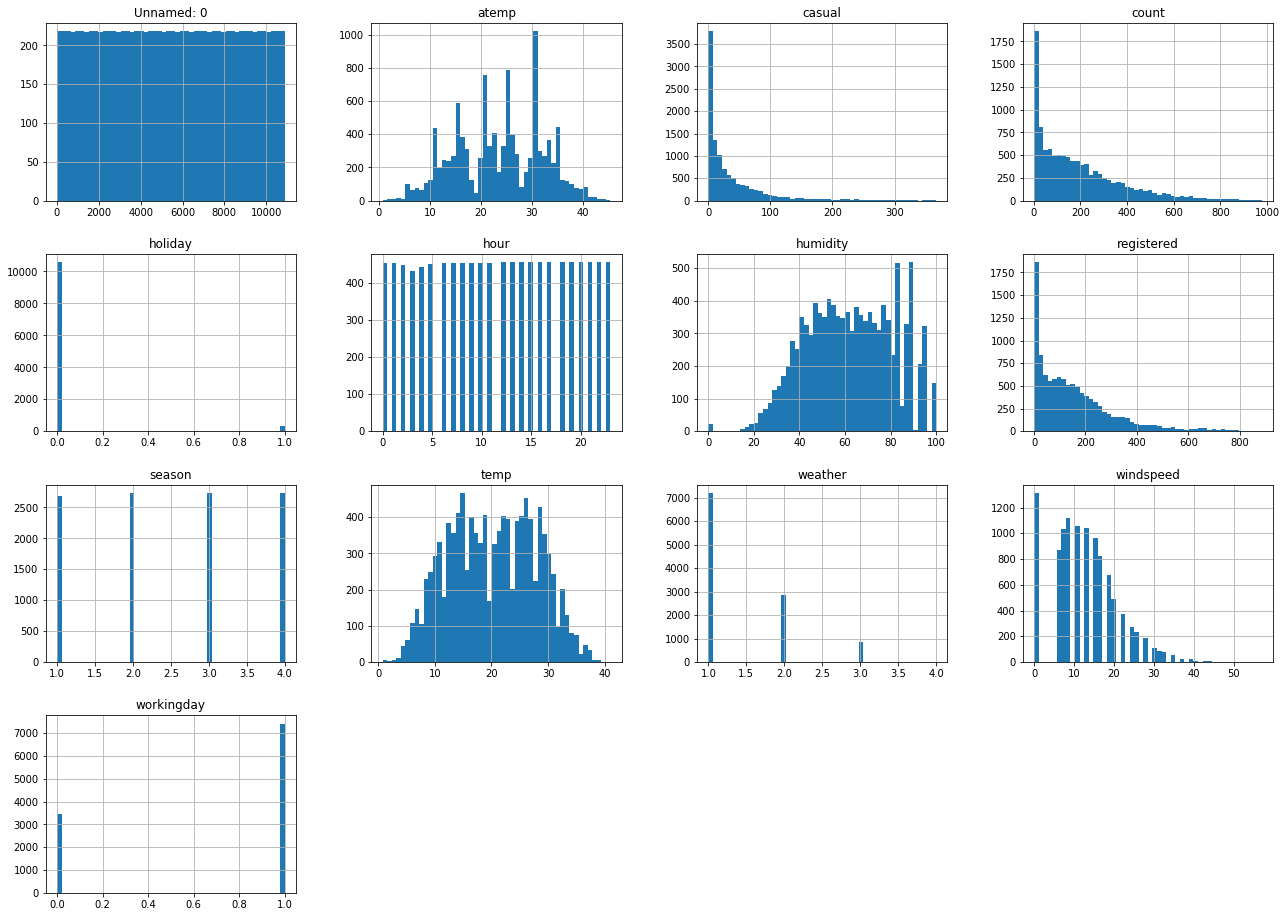

In [81]:
df.hist(bins=50, figsize=(22,16))
plt.show()

# Comentario

A continuación se describirá el dataset a utilizar:

El dataset cuenta con 10886 datos y 14 descriptores, no contiene valores faltantes y cada descriptor se define como:

    Unnamed 0: No aporta información importante para el problema
    datetime:  Fecha y hora del arriendo
    season: estación siendo primeravera, verano, otoño e invierno parametrizados como 1,2,3,4 respectivamente
    holiday: Día considerado feriado
    workingday: Día considerado día laboral
    weather: combinación de climas posibles, los cuales son:
    
        1 = Despejado, pocas nubes, algunas nubes
        2 = neblina + nublado, neblina + nubes de lluvia, neblinas + algunas nubes, solo neblina
        3 = pequeña nevada, llovizna + truenos + nubes de tormenta, llovizna + nubes de tormenta
        4 = Fuerte lluvia + pequeño granizo + tormenta eléctrica + neblina, nieve + neblina 
    
    temp: temperatura en grados celsius
    atemp: sensación termina en celsius
    humidity: humedad relativa
    windpseed: velocidad del viento
    casual: arriendos de no registrados
    registered: arriendos de registrados
    count: numero total de arriendos
    hour: hora del día
    
Se destaca que count es la suma de casual + registered, por lo cual se detectan descriptores que son linealmente dependientes y solamente se trabajara con count para eliminar dicho problema.

Por último, por los histogramas, podemos decir que ciertos parametros siguen distribuciones "casi" normales, como por ejemplo temp, humidity y atemp, además, claramente por la distribución de Unnamed0, podemos reconoce que no es útil y podemos removerlo.

Con respecto a las características que no siguen una distribución "normal" como count, una posible aproximación sería eliminar el claro outlier al principio y aplicar el logaritmo a la característica, esto permitiría tener una aproximación cercana mas no perfecta de una distribución normal.

(b) Entrene un árbol de regresión para resolver el problema usando parámetros por defecto. Con este
fin, construya una matriz Xtrain de forma ntrain × d1 que contenga los datos de entrenamiento en sus
filas, seleccionando las columnas que desee/pueda utilizar para el entrenamiento. Implemente además, la
función de evaluación que hemos definido anteriormente para este problema. Evalúe el árbol de regresión
ajustado a los datos de entrenamiento sobre el conjunto de entrenamiento y pruebas. Construya un
gráfico que compare las predicciones con los valores reales. En este punto usted debiese tener un modelo
con puntaje del orden de 0.59, lo que lo dejará más o menos en la posición 2140 de la competencia.

SCORE TEST=0.703388
KAGG EVAL TRAIN =0.028516
KAGG EVAL VAL =0.554511
KAGG EVAL TEST =0.574239


/home/gabo/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


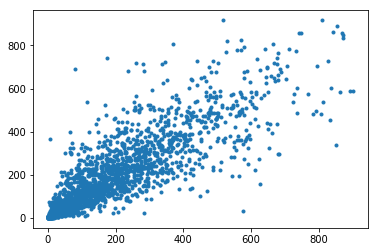

In [82]:
def eval_bikemodel(y_predict,y_true):
    diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))
Xdf=df.ix[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour']]
Ydf=df.ix[:,'count']
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values
Y_true_test = Y_test
X_true_test = X_test

model = Tree(random_state=0)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print("SCORE TEST=%f"%score_test)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_true_test)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_true_test)

print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL VAL =%f"%kagg_val)
print("KAGG EVAL TEST =%f"%kagg_test)
plt.plot(Y_test,Y_pred_test,'.')
plt.show()

# Comentario:

Podemos ver que el error de validación es sumamente cercano al de prueba, por lo cual podemos comprobar que el set de validación si da un buen antecedente de como le va a nuestro modelo (ya que en ciertos casos puede ser muy distinto los valores)

(c) Mejore el árbol de regresión definido en el punto anterior haciendo modificaciones a los hiper-parámetros
del modelo. Por ejemplo, como estos modelos tienden a sobre-ajustar, podría intentar limitar la
profundidad del árbol (¿Por qué esto debiese ayudar?). Naturalmente, está absolutamente prohibido
tomar este tipo de decisiones en función del resultado de pruebas. Debe realizar estas elecciones evaluando
sobre el conjunto de validación. Si no desea utilizarlo, y prefiere implementar validación cruzada
u otra técnica automática, tiene la ventaja de poder usar el conjunto de validación como parte del
entrenamiento. Con estas modificaciones debiese poder mejorar su ranking en unas 300 posiciones.

In [83]:
def plot_tree(minimo, maximo,X_train,X_val,X_test,y_train,y_val,y_test):
    profundidad = range(minimo,maximo)
    error_train= []
    error_test = []
    error_val = []
    
    for c in profundidad:
        model= Tree()
        model.set_params(max_depth=c,splitter='best')
        model.fit(X_train,y_train)
        yhat_train = model.predict(X_train)
        yhat_test = model.predict(X_test)
        yhat_val = model.predict(X_val)
        error_train.append(eval_bikemodel(yhat_train,y_train))
        error_test.append(eval_bikemodel(yhat_test,y_test))
        error_val.append(eval_bikemodel(yhat_val,y_val))
        
        
        
    plt.figure(figsize=(15,10))
    plot = plt.subplot(1,1,1)
    plot.plot(profundidad, error_train, label='Error de Entrenamiento ')
    plot.plot(profundidad, error_test, label='Error de Prueba')
    plot.plot(profundidad, error_val, label='Error de Validación ')
    
    plt.legend()
    plt.xlabel('Profundidad del Árbol')
    plt.ylabel('Error de Clasificación')
    plt.axis([minimo,maximo,0.0, 1])

    plt.show()

In [84]:
dftrain = pd.read_csv('./dataset2/bike_sharing_train.csv')
dfval = pd.read_csv('./dataset2/bike_sharing_val.csv')
dftest = pd.read_csv('./dataset2/bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['hour'] = pd.to_numeric(df['hour'])

Xdf=df.ix[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour']]
Ydf=df.ix[:,'count']
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values

model = Tree(random_state=0,max_depth=8)
model.fit(X_train,Y_train)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_true_test)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_true_test)

print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL VAL =%f"%kagg_val)
print("KAGG EVAL TEST =%f"%kagg_test)

KAGG EVAL TRAIN =0.436625
KAGG EVAL VAL =0.486956
KAGG EVAL TEST =0.518098


/home/gabo/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


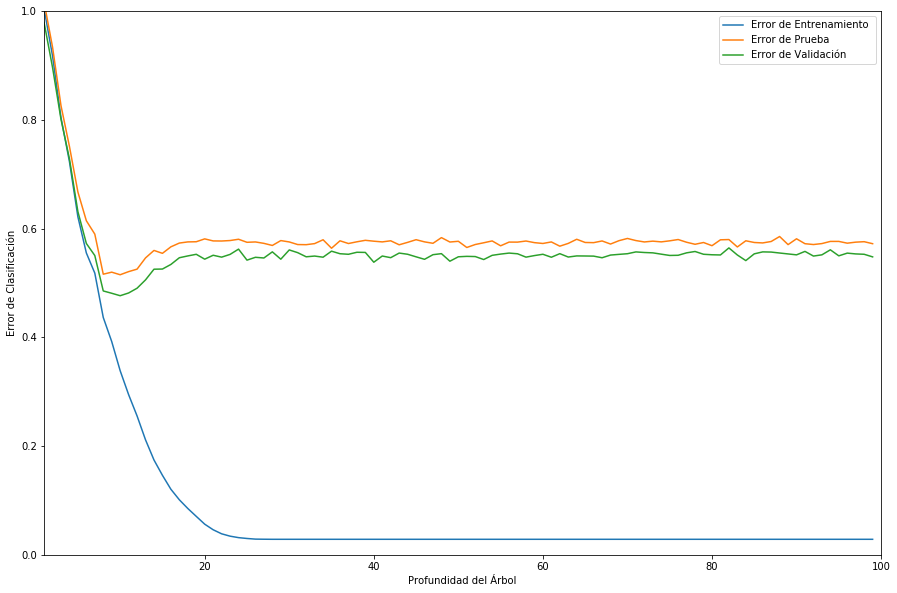

In [85]:
plot_tree(1,100,X_train ,X_val,X_true_test,Y_train,Y_val ,Y_true_test)

# Comentario:

Como se puede apreciar, la profundidad máxima del árbol donde el resultado de test validación son los mas bajos se da a una altura = 8, pasado esta altura la máquina entra ya en el overfitting, reduciendo su generalización. Por lo cual la conclusión es que tenemos que regularizar lo justo y necesario para conseguir un modelo de árboles adecuado para este caso.

(d) Mejore el árbol de regresión definido en el punto anterior haciendo modificaciones sobre la representación
utilizada para aprender desde los datos. Por ejemplo, los histogramas que construyó en el punto
(a) así como la forma especial de la función de evaluación, sugieren una cierta transformación de la
variable respuesta. Podría intentar también normalizando los datos o normalizando la respuesta. Otra
opción es intentar rescatar algo más acerca de la fecha (anteriormente sólo se extrajo la hora), como por
ejemplo el año o el día de la semana (’lunes’,’martes’, etc) que corresponde. Sea creativo, este paso le
debiese reportar un salto de calidad muy significativo. Una observación importante es que si hace una
transformación a la variable respuesta (por ejemplo raíz cuadrada), debe invertir esta transformación
antes de evaluar el desempeño con eval bikemodel (por ejemplo, elevar al cuadrado si tomó raíz cuadrada).
Con modificaciones de este tipo, podría mejorar su ranking en unas 1000 posiciones, entrando
ya al top-1000 con un score del orden de 0.45.

# Analisis:

Para esta pregunta, seguiremos la opción de realizar feature crafting, para ello primero daremos una vista a la correlación de las características del dataset mediante un mapa de calor:

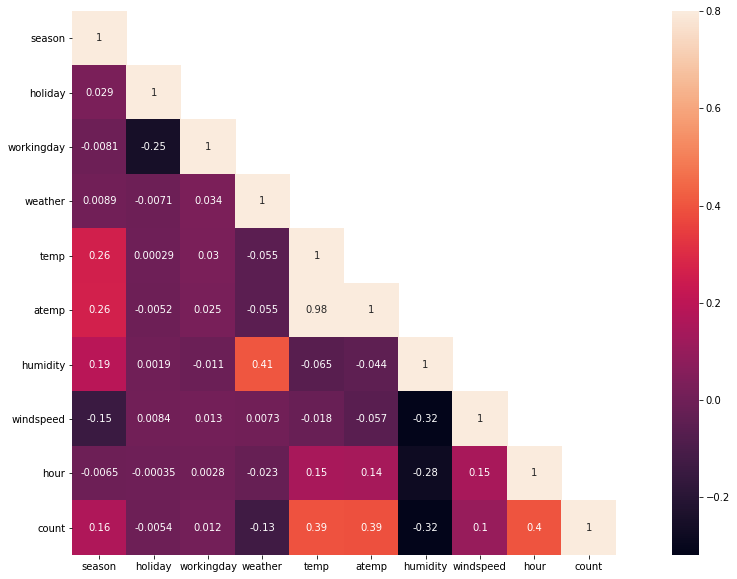

In [86]:
corrMatt = df[['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','count']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
plt.show()

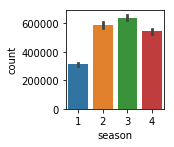

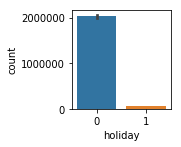

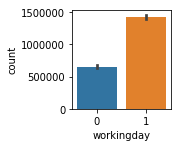

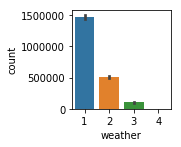

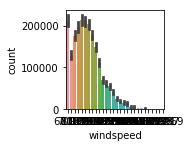

In [87]:
cat_names=['season', 'holiday', 'workingday', 'weather','windspeed']
i=1
for name in cat_names:
    plt.subplot(2,3,i)
    sns.barplot(x=name,y='count',data=df,estimator=sum)
    i=i+1
    plt.show()

Como podemos ver, existen características poco correlacionadas, siendo estas windspeed, workingday, holiday y season, por temas de mantener la actividad relacionada con el item anterior, se eliminaran características que no aportar al problema, las cuales son:

    1) datetime: se elimina por que se reconstruirá con feature crafting en forma de año, mes, día y hora
    2) atemp: al ser la sensación térmica de las personas, esta fuertemente relacionada con temp que es la temperatura actual, por lo cual para evitar problemas de posible dependencia lineal, la eliminaremos .
    3) windspeed: Por el gráfico de correlación,no va a caso analizar esta características, además, es poco natural    pensar que la velocidad del viento afecte el uso de las bicicletas, por ende, su arriendo.
    4) casual y registered se eliminan ya que su información se encuentra en la variable objetivo count
    5) unnamed:0 : como anteriormente hemos dicho, no sabemos que significa esta característica por lo cual se elimina por temas de conveniencia.



In [88]:
dftrain = pd.read_csv('./dataset2/bike_sharing_train.csv')
dfval = pd.read_csv('./dataset2/bike_sharing_val.csv')
dftest = pd.read_csv('./dataset2/bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])

new_df=df.copy()
new_df['datetime']=new_df['datetime'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
new_df['year']=new_df['datetime'].apply(lambda x:x.year)
new_df['month']=new_df['datetime'].apply(lambda x:x.month)
new_df['day']=new_df['datetime'].apply(lambda x:x.day)
new_df['hour'] = pd.to_datetime(new_df['datetime']).apply(lambda x: x.strftime('%H'))
new_df['hour'] = pd.to_numeric(new_df['hour'])

final_df=new_df.drop(['datetime','atemp','windspeed','casual','registered','Unnamed: 0'], axis=1)

Finalmente, realizamos un histograma de las características del dataset, para determinar que variables son categóricas y cuales no:

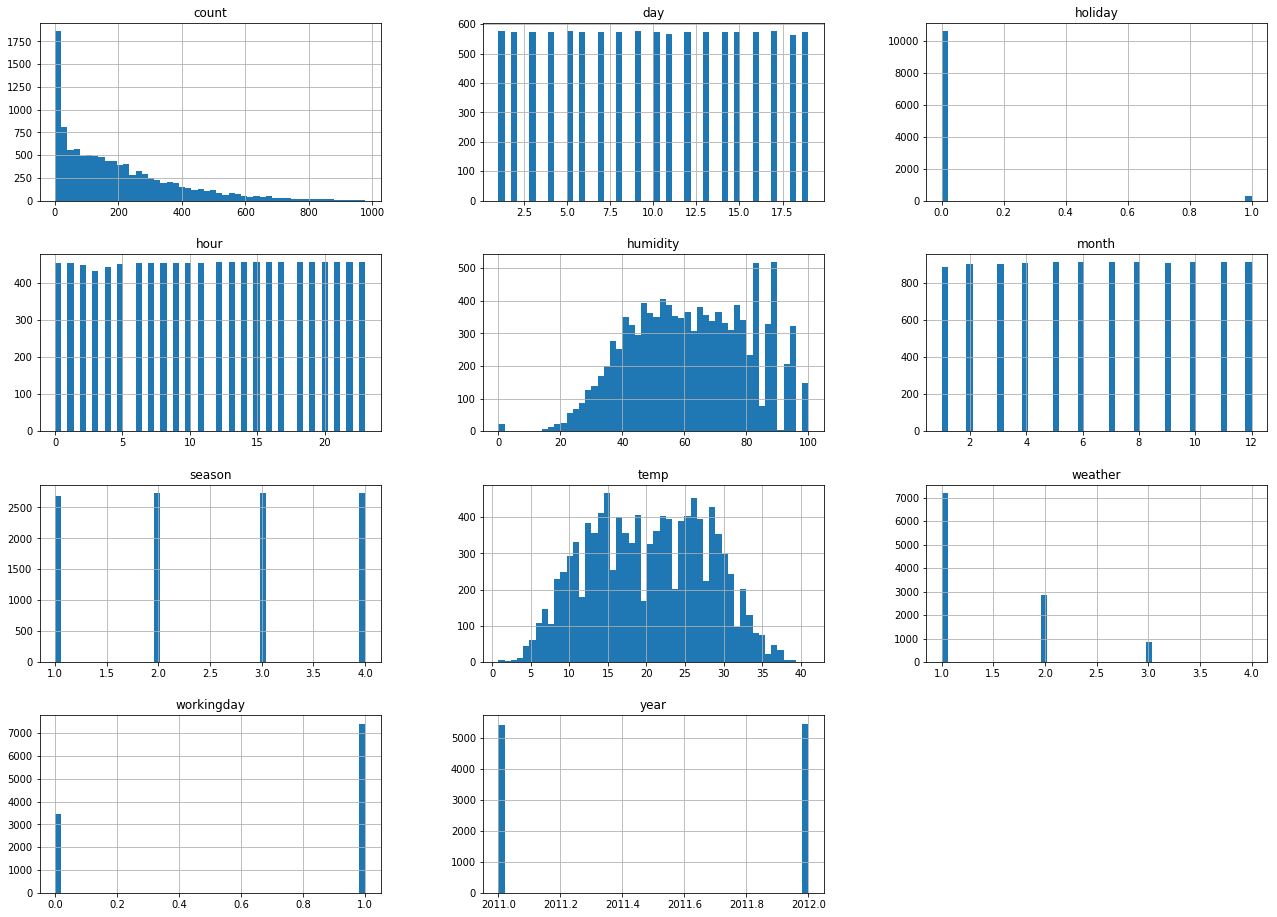

,season,holiday,workingday,weather,temp,humidity,count,year,month,day,hour
0,1,0,0,1,9.84,75,13,2011,1,1,3
1,1,0,0,1,9.84,75,1,2011,1,1,4
2,1,0,0,2,9.84,75,1,2011,1,1,5
3,1,0,0,1,9.02,80,2,2011,1,1,6
4,1,0,0,1,8.20,86,3,2011,1,1,7


In [89]:
final_df=new_df.drop(['datetime','atemp','windspeed','casual','registered','Unnamed: 0'], axis=1)
final_df.hist(bins=50, figsize=(22,16))
plt.show()
final_df.head()

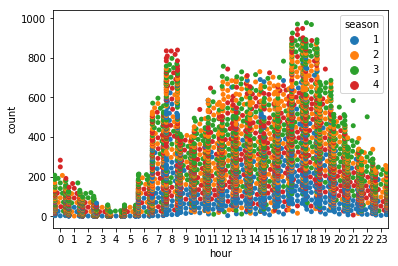

In [90]:
sns.swarmplot(x='hour',y='count',data=new_df,hue='season')
plt.show()

Finalmente entrenmiento nuestra maquina:

In [91]:
Xdf = final_df.iloc[:,final_df.columns!='count'].values
Ydf=final_df.iloc[:,6].values
X_train = Xdf[0:ntrain]
X_val = Xdf[ntrain:nval]
X_test = Xdf[nval:]
Y_train = Ydf[0:ntrain]
Y_val = Ydf[ntrain:nval]
Y_test = Ydf[nval:]



model = Tree(random_state=0,max_depth=10)
model.fit(X_train,Y_train)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_true_test)

print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL VAL =%f"%kagg_val)
print("KAGG EVAL TEST =%f"%kagg_test) 

KAGG EVAL TRAIN =0.269360
KAGG EVAL VAL =0.414898
KAGG EVAL TEST =0.420140


Como podemos observar, al hacer el feature crafting mejoramos mucho la maquina, bajando de un 51% de error a un 42%, 9% de mejora con el sample de prueba. Por lo cual podemos concluir que nuestro feature crafting si fue util para mejorar el modelo, ademas que la eliminación de ciertos atributos innecesarios tambien ayudo a la mejora.
Una opción que mejoraria aun mas el modelo es aplicar criterios ma avanzados en feature crafting o aplicar algun tipo de estandaruzación adecuada al modelo, ya que en los casos de prueba, la estandarización solo empeoraba la maquina (por esta razón no se aplico)

(e) Entrene una SVM no lineal para resolver el problema midiendo el efecto de las distintas representaciones
que haya descubierto hasta este punto. Un detalle importante es que antes de entrenar la SVM sería
aconsejable hacer dos tipos de pre-procesamiento adicional de los datos: (i) codificar las variables
categóricas en un modo apropiado - por ejemplo como vector binario con un 1 en la posición del
valor adoptado-, (ii) escalar los atributos de modo que queden centrados y con rangos comparables.
Usando parámetros por defecto para la SVM debiese obtener un score del orden de 0.344, quedando
definitivamente en el top-10 de la competencia.

In [92]:
#Modelo Orginal
dftrain = pd.read_csv('./dataset2/bike_sharing_train.csv')
dfval = pd.read_csv('./dataset2/bike_sharing_val.csv')
dftest = pd.read_csv('./dataset2/bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)

df = pd.concat([dftrain,dfval,dftest])
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek
df['hour'] = pd.to_numeric(df['hour'])
df['cday'] = pd.to_numeric(df['cday'])
Xdf=df.ix[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday']]
Xdf = pd.get_dummies(Xdf,columns=['season', 'weather','hour','cday'])
Ydf=df.ix[:,'count']

X_train = Xdf[0:ntrain]
X_val = Xdf[ntrain:nval]
X_test = Xdf[nval:]
Y_train = Ydf[0:ntrain]
Y_val = Ydf[ntrain:nval]
Y_test = Ydf[nval:]

Y_train_normal = Y_train
Y_val_normal = Y_val

Y_train = np.log(Y_train+1)
Y_val = np.log(Y_val+1)


scalerX = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_val = scalerX.fit_transform(X_val)
X_test = scalerX.transform(X_test)

model = SVR()
model.fit(X_train,Y_train)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

kagg_train = eval_bikemodel(np.exp(Y_pred_train),Y_train_normal)
kagg_val = eval_bikemodel(np.exp(Y_pred_val),Y_val_normal)
kagg_test = eval_bikemodel(np.exp(Y_pred_test),Y_test)

print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL VAL =%f"%kagg_val)
print("KAGG EVAL TEST =%f"%kagg_test)



/home/gabo/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


KAGG EVAL TRAIN =0.337720
KAGG EVAL VAL =0.404797
KAGG EVAL TEST =0.423907


In [93]:
#modelo mejorado
final_df
Xdf=final_df.ix[:,['season','holiday','workingday','weather','temp','humidity','year','month','day','hour']]
Xdf = pd.get_dummies(Xdf,columns=['season','holiday','workingday', 'weather','year','month','day','hour'])
Ydf=final_df.ix[:,'count']


X_train = Xdf[0:ntrain]
X_val = Xdf[ntrain:nval]
X_test = Xdf[nval:]
Y_train = Ydf[0:ntrain]
Y_val = Ydf[ntrain:nval]
Y_test = Ydf[nval:]

Y_train_normal = Y_train
Y_val_normal = Y_val

Y_train = np.log(Y_train+1)
Y_val = np.log(Y_val+1)

scalerX = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_val = scalerX.fit_transform(X_val)
X_test = scalerX.transform(X_test)

model = SVR()
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

kagg_train = eval_bikemodel(np.exp(Y_pred_train),Y_train_normal)
kagg_val = eval_bikemodel(np.exp(Y_pred_val),Y_val_normal)
kagg_test = eval_bikemodel(np.exp(Y_pred_test),Y_test)

print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL VAL =%f"%kagg_val)
print("KAGG EVAL TEST =%f"%kagg_test)

/home/gabo/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


KAGG EVAL TRAIN =0.239207
KAGG EVAL VAL =0.334269
KAGG EVAL TEST =0.355398


# Comentario:

Como se puede observar el modelo de prueba otorgado llega a un 42% de error en el test sample (luego de hacer todos los ajustes con el set de validación) mientras que el modelo obtenido en la sección de arboles aplicado a una SVM obtuvo un mejor resultado siendo este 35% comparado al test sample (todo esto considerando que se le realizo una transformación al logaritmo a la función objetivo, se generaron dummys para lidiar con las variables categóricas y se aplico una estandarización a los subset X) por lo cual nuestro equipo concluye que el feature crafting mejoro el modelo de arboles y de SVM pero en el caso de la SVM si se pudo aplicar una estandarización que mejorara el modelo (ya que en arboles lo empeoraba).

(f) Mejore la SVM definida en el punto anterior haciendo modificaciones a los hiper-parámetros de la
máquina (C, $\epsilon$ o la misma función de kernel). Naturalmente, está absolutamente prohibido tomar este
tipo de decisiones de diseño mirando el resultado de pruebas. Debe realizar estas elecciones evaluando
sobre el conjunto de validación. Si no desea utilizarlo, y prefiere implementar validación cruzada
u otra técnica automática, tiene la ventaja de poder usar el conjunto de validación como parte del
entrenamiento

In [94]:
def SVR_tarea3(kernel,x_tr, x_v, x_t, y_tr, y_v , y_t,y_trl,y_vl): 
    error_train = []
    error_test = []
    error_val = []
    
    pasos = [1,2,3,4,5,6,7,8,9,10,11,12]
    Cs = [1,5,10,20,30,40,50,60,70,80,90,100]
    for i,param in enumerate((1,5,10,20,30,40,50,60,70,80,90,100)):            
        

        model = SVR()
        model.set_params(C=param,kernel=kernel,epsilon=0.01)
        model.fit(x_tr,y_tr)          
        
        yhat_train = model.predict(x_tr)
        yhat_test = model.predict(x_t)
        yhat_val = model.predict(x_v)
        
        
        error_train.append(eval_bikemodel(np.exp(yhat_train),y_trl))
        error_test.append(eval_bikemodel(np.exp(yhat_test),y_t))
        error_val.append(eval_bikemodel(np.exp(yhat_val),y_vl))
        

    plt.figure(figsize=(10,15))
    plot = plt.subplot(2,1,1)
    plot.plot(pasos, error_train, label='Error de Entrenamiento ')
    plot.plot(pasos, error_test, label='Error de Prueba')
    plot.plot(pasos, error_val, label='Error de Validación ')
    plt.legend()
    plt.title('SVM con kernel '+kernel)
    plt.xlabel('Valor del Parametro C')
    plt.ylabel('Error de Clasificación')
    plt.axis([1,2,0, 1])
    plt.xticks(pasos, Cs)
    plt.tight_layout()
    plt.show()

In [95]:
def SVR_tarea3_2(kernel,x_tr, x_v, x_t, y_tr, y_v , y_t,y_trl,y_vl): 
    error_train = []
    error_test = []
    error_val = []
    
    pasos = [1,2,3,4,5]
    Cs = [0.1,0.3,0.7,0.8,1]
    for i,param in enumerate((0.1,0.3,0.7,0.8,1)):            
        

        model = SVR()
        model.set_params(C = 100,epsilon=param,kernel=kernel)
        model.fit(x_tr,y_tr)          
        
        yhat_train = model.predict(x_tr)
        yhat_test = model.predict(x_t)
        yhat_val = model.predict(x_v)
        
        
        error_train.append(eval_bikemodel(np.exp(yhat_train),y_trl))
        error_test.append(eval_bikemodel(np.exp(yhat_test),y_t))
        error_val.append(eval_bikemodel(np.exp(yhat_val),y_vl))
        

    plt.figure(figsize=(10,15))
    plot = plt.subplot(2,1,1)
    plot.plot(pasos, error_train, label='Error de Entrenamiento ')
    plot.plot(pasos, error_test, label='Error de Prueba')
    plot.plot(pasos, error_val, label='Error de Validación ')
    plt.legend()
    plt.title('SVM con kernel '+kernel)
    plt.xlabel('Valor del Parametro epsilon')
    plt.ylabel('Error de Clasificación')
    plt.axis([1,2,0, 1])
    plt.xticks(pasos, Cs)
    plt.tight_layout()
    plt.show()

In [96]:
Xdf=final_df.ix[:,['season','holiday','workingday','weather','temp','humidity','year','month','day','hour']]
Xdf = pd.get_dummies(Xdf,columns=['season','holiday','workingday', 'weather','year','month','day','hour'])
Ydf=final_df.ix[:,'count']

X_train = Xdf[0:ntrain]
X_val = Xdf[ntrain:nval]
X_test = Xdf[nval:]
Y_train = Ydf[0:ntrain]
Y_val = Ydf[ntrain:nval]
Y_test = Ydf[nval:]


scalerX = RobustScaler()
X_train = scalerX.fit_transform(X_train)
X_val = scalerX.fit_transform(X_val)
X_test = scalerX.transform(X_test)

Y_train_normal = Y_train
Y_val_normal = Y_val

Y_train = np.log(Y_train+1)
Y_val = np.log(Y_val+1)

model = SVR(C=100,epsilon=0.01)
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

kagg_train = eval_bikemodel(np.exp(Y_pred_train),Y_train_normal)
kagg_val = eval_bikemodel(np.exp(Y_pred_val),Y_val_normal)
kagg_test = eval_bikemodel(np.exp(Y_pred_test),Y_test)

print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL VAL =%f"%kagg_val)
print("KAGG EVAL TEST =%f"%kagg_test)

KAGG EVAL TRAIN =0.266836
KAGG EVAL VAL =0.313195
KAGG EVAL TEST =0.339924


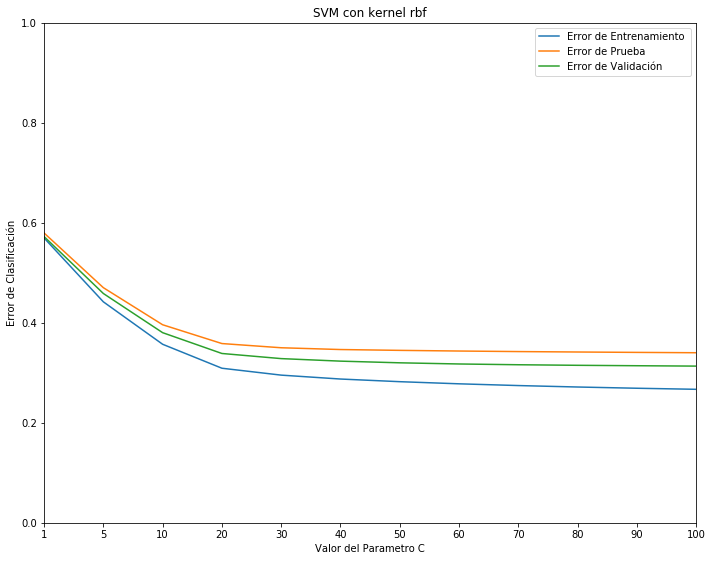

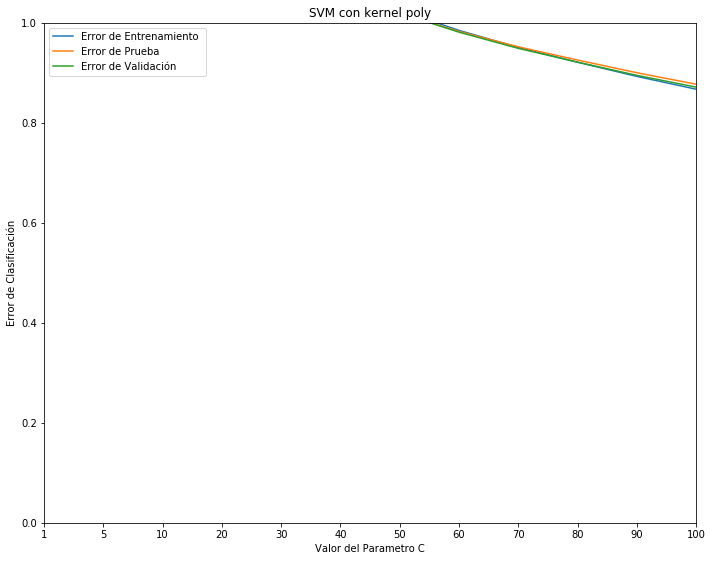

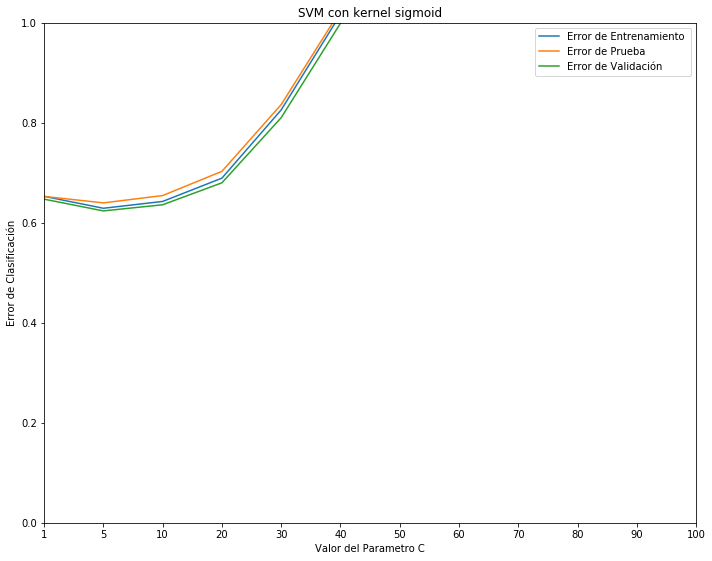

In [97]:
Xdf=final_df.ix[:,['season','holiday','workingday','weather','temp','humidity','year','month','day','hour']]
Xdf = pd.get_dummies(Xdf,columns=['season','holiday','workingday', 'weather','year','month','day','hour'])
Ydf=final_df.ix[:,'count']

X_train = Xdf[0:ntrain]
X_val = Xdf[ntrain:nval]
X_test = Xdf[nval:]
Y_train = Ydf[0:ntrain]
Y_val = Ydf[ntrain:nval]
Y_test = Ydf[nval:]

scalerX = RobustScaler()
X_train = scalerX.fit_transform(X_train)
X_val = scalerX.fit_transform(X_val)
X_test = scalerX.transform(X_test)

Y_train_normal = Y_train
Y_val_normal = Y_val

Y_train = np.log(Y_train+1)
Y_val = np.log(Y_val+1)

SVR_tarea3('rbf',X_train, X_val, X_test, Y_train, Y_val , Y_test,Y_train_normal,Y_val_normal)
SVR_tarea3('poly',X_train, X_val, X_test, Y_train, Y_val , Y_test,Y_train_normal,Y_val_normal)
SVR_tarea3('sigmoid',X_train, X_val, X_test, Y_train, Y_val , Y_test,Y_train_normal,Y_val_normal)

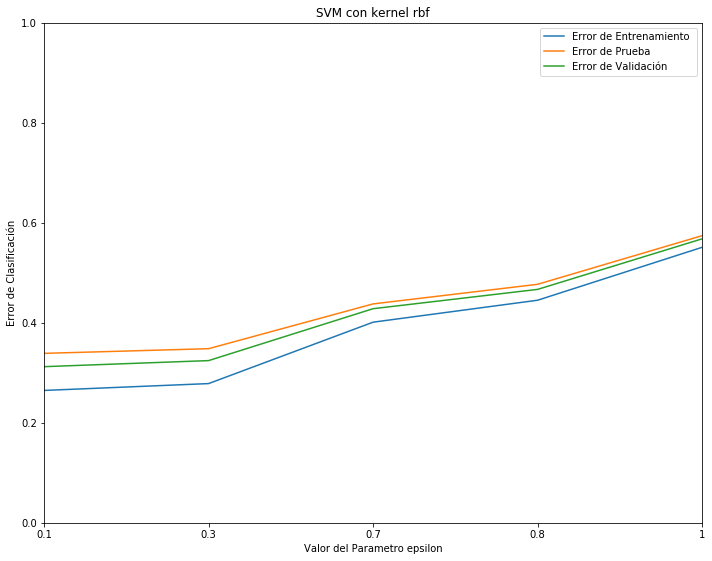

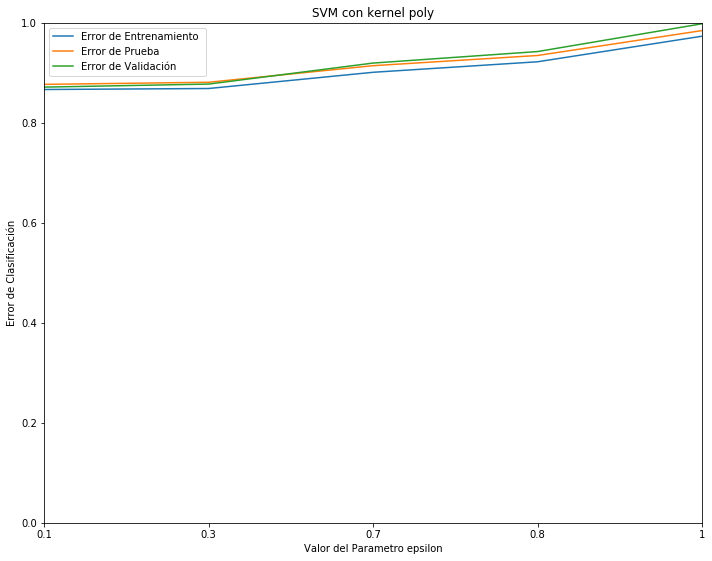

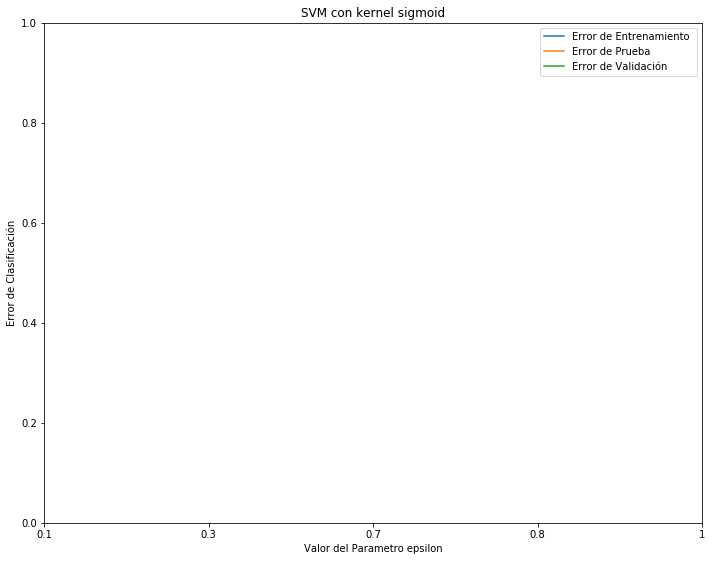

In [98]:
SVR_tarea3_2('rbf',X_train, X_val, X_test, Y_train, Y_val , Y_test,Y_train_normal,Y_val_normal)
SVR_tarea3_2('poly',X_train, X_val, X_test, Y_train, Y_val , Y_test,Y_train_normal,Y_val_normal)
SVR_tarea3_2('sigmoid',X_train, X_val, X_test, Y_train, Y_val , Y_test,Y_train_normal,Y_val_normal)

Para este caso, se realizo cambios tanto para el parametro regularizador C y el parametro epsilon, luego de realizar todas las pruebas y ajustes con el set de validación, se encontró que el mejor parametro regularizado es C = 100 y el epsilon = 0.1 obteniendo un 33% de error en el test sample, si elegimos un valor más pequeño que C = 100, entrenaremos una peor maquina ya que el error aumenta y superior a esto no se notan cambios significativos al error. Por otro lado el parametro sigma solo nos causa problemas si lo incrementamos, ya que a medida que aumenta, también incrementamos este error, por lo cual la conclusión es que tenemos que regularizar moderadamente para que la maquina tiene una buena generalización para el caso de una SVM (Considerar que todas estas pruebas se hicieron con el dataset reducido entrado en la sección de arboles aplicando los dummys y las estandarizaciones adecuadas).


(g) Evalúe el efecto de utilizar el dataset de validación para entrenamiento y seleccionar los parámetros
estructurales del árbol de clasificación y la SVM usando validación cruzada. El código de ejemplo para
esto ha sido proporcionado en las tareas 1 y 2, pero se adjunta de nuevo a continuación

# Árbol

In [120]:
dftrain = pd.read_csv('./dataset2/bike_sharing_train.csv')
dfval = pd.read_csv('./dataset2/bike_sharing_val.csv')
dftest = pd.read_csv('./dataset2/bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])

new_df=df.copy()
new_df['datetime']=new_df['datetime'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
new_df['year']=new_df['datetime'].apply(lambda x:x.year)
new_df['month']=new_df['datetime'].apply(lambda x:x.month)
new_df['day']=new_df['datetime'].apply(lambda x:x.day)
new_df['hour'] = pd.to_datetime(new_df['datetime']).apply(lambda x: x.strftime('%H'))
new_df['hour'] = pd.to_numeric(new_df['hour'])
final_df=new_df.drop(['datetime','atemp','windspeed','casual','registered','Unnamed: 0'], axis=1)

Xdf = final_df.iloc[:,final_df.columns!='count'].values
Ydf=final_df.iloc[:,6].values
Xm = Xdf[0:nval]
X_test = Xdf[nval:]
ym = Ydf[0:nval]
Y_test = Ydf[nval:]

n=10

kf = KFold(n_splits=n)
mse_cv = 0
for train, val in kf.split(Xm):
    model = Tree(random_state=0,max_depth=10)
    model.fit(Xm[train], ym[train])
    yhat_val = model.predict(Xm[val])
    ytrue_val = ym[val]
    score_fold = eval_bikemodel(yhat_val,ytrue_val)
    mse_cv += score_fold
mse_cv = mse_cv / n


Y_pred_test = model.predict(X_test)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)

print("KAGG EVAL VAL =%f"%mse_cv)
print("KAGG EVAL TEST =%f"%kagg_test) 

KAGG EVAL VAL =0.440383
KAGG EVAL TEST =0.429934


# SVM

In [116]:
Xdf=final_df.ix[:,['season','holiday','workingday','weather','temp','humidity','year','month','day','hour']]
Xdf = pd.get_dummies(Xdf,columns=['season','holiday','workingday', 'weather','year','month','day','hour'])
Ydf=final_df.ix[:,'count']

Xm = Xdf[0:ntrain]
X_test = Xdf[nval:]
Ym = Ydf[0:ntrain]
Y_test = Ydf[nval:]

scalerX = RobustScaler()
Xm = scalerX.fit_transform(Xm)
X_test = scalerX.transform(X_test)

ym = np.log(Ym+1)

n = 15

kf = KFold(n_splits=n)
mse_cv = 0
for train, val in kf.split(Xm):
    model = SVR(C=100,epsilon=0.01)
    model.fit(Xm[train], ym[train])
    yhat_val = model.predict(Xm[val])
    ytrue_val = ym[val]
    score_fold = eval_bikemodel(yhat_val,ytrue_val)
    mse_cv += score_fold
mse_cv = mse_cv / n


Y_pred_test = model.predict(X_test)
kagg_test = eval_bikemodel(np.exp(Y_pred_test),Y_test)

print("KAGG EVAL VAL =%f"%mse_cv)
print("KAGG EVAL TEST =%f"%kagg_test) 


KAGG EVAL VAL =0.102756
KAGG EVAL TEST =0.349351


# Comentario:

Extrañamente, cross validation solamente empeoro los resultados obtenidos anteriormente pero en fracciones muy ínfimas, por lo cual esta aproximación no es recomendable. Esto se puede deber a ya de por si la muestra es representativa, por lo cual al hacer los folds, entrenamos la maquina sobre varios conjuntos representativos, generando overfitting y obteniendo peores resultados.
Por otra parte, el costo computacional aumenta sobre SVM, esto se debe a que el problema es multivariado y al hacer el ajuste demora mucho en los calculos en comparaciones a árboles.

(h) Evalúe el efecto de utilizar un ensamblado de 2 máquinas de aprendizaje para predecir la demanda
total de bicicletas. Un modelo se especializará en la predicción de la demanda de bicicletas de parte
de usuarios registrados y otra en la predicción de la demanda de usuarios casuales. Hay razones claras
para pensar que los patrones son distintos.

# SVM

In [125]:
dftrain = pd.read_csv('./dataset2/bike_sharing_train.csv')
dfval = pd.read_csv('./dataset2/bike_sharing_val.csv')
dftest = pd.read_csv('./dataset2/bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])

new_df=df.copy()
new_df['datetime']=new_df['datetime'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
new_df['year']=new_df['datetime'].apply(lambda x:x.year)
new_df['month']=new_df['datetime'].apply(lambda x:x.month)
new_df['day']=new_df['datetime'].apply(lambda x:x.day)
new_df['hour'] = pd.to_datetime(new_df['datetime']).apply(lambda x: x.strftime('%H'))
new_df['hour'] = pd.to_numeric(new_df['hour'])
final_df=new_df.drop(['datetime','atemp','windspeed','Unnamed: 0'], axis=1)

Xdf=final_df.ix[:,['season','holiday','workingday','weather','temp','humidity','year','month','day','hour']]
Xdf = pd.get_dummies(Xdf,columns=['season','holiday','workingday', 'weather','year','month','day','hour'])

X_train = Xdf[0:ntrain]
X_val = Xdf[ntrain:nval]
X_test = Xdf[nval:]

scalerX = RobustScaler()
X_train = scalerX.fit_transform(X_train)
X_val = scalerX.fit_transform(X_val)
X_test = scalerX.transform(X_test)

/home/gabo/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [134]:
Ydf_registered=np.log(final_df['registered']+1) 
Y_registered_train = Ydf_registered[0:ntrain].values
Y_registered_val = Ydf_registered[ntrain:nval].values
Y_registered_test = Ydf_registered[nval:].values

model = SVR(C = 100, kernel = 'rbf')
model.fit(X_train,Y_registered_train)

y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

kagg_val = eval_bikemodel(np.exp(y_pred_val),np.exp(Y_registered_val))
kagg_test1 = eval_bikemodel(np.exp(y_pred_test),np.exp(Y_registered_test))
print("KAGG EVAL VAL =%f"%kagg_val) 

KAGG EVAL VAL =0.277754


In [136]:
Ydf_casual=np.log(final_df['casual']+1) 
Y_casual_train = Ydf_casual[0:ntrain].values
Y_casual_val = Ydf_casual[ntrain:nval].values
Y_casual_test = Ydf_casual[nval:].values

model = SVR(C = 100, kernel = 'rbf')

model.fit(X_train,Y_casual_train)

y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

kagg_val = eval_bikemodel(np.exp(y_pred_val),np.exp(Y_casual_val))
kagg_test3 = eval_bikemodel(np.exp(y_pred_test),np.exp(Y_casual_test))
print("KAGG EVAL VAL =%f"%kagg_val) 

KAGG EVAL VAL =0.407648


In [137]:
# Resultado Test
print("KAGG EVAL TEST REGISTERED =%f"%kagg_test1) 
print("KAGG EVAL TEST CASUAL =%f"%kagg_test3) 

KAGG EVAL TEST REGISTERED =0.308338
KAGG EVAL TEST COUNT =0.315575
KAGG EVAL TEST CASUAL =0.438048


# Árboles

In [150]:
dftrain = pd.read_csv('./dataset2/bike_sharing_train.csv')
dfval = pd.read_csv('./dataset2/bike_sharing_val.csv')
dftest = pd.read_csv('./dataset2/bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])

new_df=df.copy()
new_df['datetime']=new_df['datetime'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
new_df['year']=new_df['datetime'].apply(lambda x:x.year)
new_df['month']=new_df['datetime'].apply(lambda x:x.month)
new_df['day']=new_df['datetime'].apply(lambda x:x.day)
new_df['hour'] = pd.to_datetime(new_df['datetime']).apply(lambda x: x.strftime('%H'))
new_df['hour'] = pd.to_numeric(new_df['hour'])
final_df=new_df.drop(['datetime','atemp','windspeed','Unnamed: 0'], axis=1)

Xdf=final_df.ix[:,['season','holiday','workingday','weather','temp','humidity','year','month','day','hour']]
Xdf = pd.get_dummies(Xdf,columns=['season','holiday','workingday', 'weather','year','month','day','hour'])

X_train = Xdf[0:ntrain]
X_val = Xdf[ntrain:nval]
X_test = Xdf[nval:]

/home/gabo/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [153]:
Ydf_registered=final_df['registered']
Y_registered_train = Ydf_registered[0:ntrain].values
Y_registered_val = Ydf_registered[ntrain:nval].values
Y_registered_test = Ydf_registered[nval:].values

model = Tree(random_state=0,max_depth=10)
model.fit(X_train,Y_registered_train)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel(Y_pred_train,Y_registered_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_registered_val)
kagg_test1 = eval_bikemodel(Y_pred_test,Y_registered_test)

print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL VAL =%f"%kagg_val)

KAGG EVAL TRAIN =0.939492
KAGG EVAL VAL =0.962085


In [154]:
Ydf_casual=final_df['casual']
Y_casual_train = Ydf_casual[0:ntrain].values
Y_casual_val = Ydf_casual[ntrain:nval].values
Y_casual_test = Ydf_casual[nval:].values

model = Tree(random_state=0,max_depth=10)
model.fit(X_train,Y_casual_train)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel(Y_pred_train,Y_casual_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_casual_val)
kagg_test3 = eval_bikemodel(Y_pred_test,Y_casual_test)

print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL VAL =%f"%kagg_val)

KAGG EVAL TRAIN =0.826696
KAGG EVAL VAL =0.936680


In [156]:
# Resultado Test
print("KAGG EVAL TEST REGISTERED =%f"%kagg_test1) 
print("KAGG EVAL TEST CASUAL =%f"%kagg_test3) 

KAGG EVAL TEST REGISTERED =1.001021
KAGG EVAL TEST COUNT =0.992629
KAGG EVAL TEST CASUAL =0.963068


# Comentario:

Es muy interesante que para el caso de los arboles, el resultado empeora drásticamente mientras que para SVM se comporta de mejor manera.La causa a la que llegamos de por que SVM se comporta mejor es debido a que la variable registered tiene mas información que la variable casual, por lo cual casual actúa negativamente en el modelo, obteniéndose un mejor resultado solo al analizar registered

(i) Evalúe el efecto de utilizar un algoritmo genérico para ensamblar máquinas de aprendizaje para predecir
la demanda total de bicicletas. Puede experimentar con una sola técnica (e.g. Random Forest), discuta
la evolución a medida que aumenta el número de máquinas.

In [ ]:
model = RandomForestRegressor(n_estimators=10,max_depth=max_depth,random_state=0)

In [179]:
dftrain = pd.read_csv('./dataset2/bike_sharing_train.csv')
dfval = pd.read_csv('./dataset2/bike_sharing_val.csv')
dftest = pd.read_csv('./dataset2/bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])

new_df=df.copy()
new_df['datetime']=new_df['datetime'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
new_df['year']=new_df['datetime'].apply(lambda x:x.year)
new_df['month']=new_df['datetime'].apply(lambda x:x.month)
new_df['day']=new_df['datetime'].apply(lambda x:x.day)
new_df['hour'] = pd.to_datetime(new_df['datetime']).apply(lambda x: x.strftime('%H'))
new_df['hour'] = pd.to_numeric(new_df['hour'])

final_df=new_df.drop(['datetime','atemp','windspeed','casual','registered','Unnamed: 0'], axis=1)

Xdf = final_df.iloc[:,final_df.columns!='count'].values
Ydf=final_df.iloc[:,6].values
X_train = Xdf[0:ntrain]
X_val = Xdf[ntrain:nval]
X_test = Xdf[nval:]
Y_train = Ydf[0:ntrain]
Y_val = Ydf[ntrain:nval]
Y_test = Ydf[nval:]


In [190]:
def randomF(X_train,Y_train,X_val,Y_val, estimador,profundidad): 
    lista_valores = []
    for i in range(1,estimador):
        for j in range(1,profundidad):
            model = RandomForestRegressor(n_estimators=i,max_depth=j, random_state=0)
            model.fit(X_train, Y_train)
            y_val_pred = model.predict(X_val)
            maximo = eval_bikemodel(y_val_pred,Y_val)
            lista_valores.append((model,maximo,i,j))
    sorted_scores = sorted(lista_valores, key=(lambda x: x[1]), reverse=False)
    return sorted_scores[0]
model_tupla = randomF(X_train,Y_train,X_val,Y_val, 20,20)
model_tupla

(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=18, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
 0.35575223746699736,
 18,
 15)

In [191]:
model_tupla[0].fit(X_train,Y_train)
Y_pred_test = model.predict(X_test)

kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print("KAGG EVAL TEST =%f"%kagg_test) 

KAGG EVAL TEST =0.384154


# Comentario:

Como se puede destacar, el mejor resultado que se obtuvo en una iteración de 20x20 en los hyperparametros del modelo fue de profundidad 15 y un estimador de 18 el cual dio un resultado de 0.35 que para ser fácilmente implementable y que se realizo mucho trabajo preprocesando los datos mas de lo ya echo, el resultado es sumamente bueno y se estima que si se trabajara mas en esta técnica (dedicadamente parametro y haciendo preprocesados adecuados para esta) se podría llegar a incluso mejores resultados.